# 1. Импорт

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import plotly.graph_objects as go

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

import torch as th
import torch.nn as nn
import torch.optim as optim

# 2. Анализ данных

In [5]:
data = pd.read_csv('/kaggle/input/pred-prices/train.csv')
data.head()

,id,Тип,Подтверждено риэлтором,Количество розеток,Долгота,Количество зеркал,Цвет стен,Ремонтируется,Перепродажа,Готово к сдаче,Кол-во комнат,Площадь (фут²),Адрес,Широта,Опубликовано,Цена
0,0,BHK,0,7,12.969910,0,Зеленый,0,1,1,3,1510.269835,"Amruthnagar,Bangalore",77.597960,Owner,75.0
1,1,BHK,0,1,21.158795,0,Золотистый,0,1,1,3,1365.103003,"Shankar Nagar,Amravati",77.317542,Owner,55.0
2,2,BHK,0,1,30.689021,0,Черный,0,1,1,2,1200.000000,"Mdc Sector-4,Panchkula",76.860403,Dealer,79.5
3,3,BHK,0,6,28.385415,0,Серый,0,1,1,3,1785.469029,"Sector-82A Gurgaon,Gurgaon",76.964613,Dealer,130.0
4,4,BHK,0,4,18.972317,2,Фиолетовый,0,1,1,3,2500.000000,"Breach Candy,Lalitpur",72.806327,Dealer,2550.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      22000 non-null  int64  
 1   Тип                     22000 non-null  object 
 2   Подтверждено риэлтором  22000 non-null  int64  
 3   Количество розеток      22000 non-null  int64  
 4   Долгота                 22000 non-null  float64
 5   Количество зеркал       22000 non-null  int64  
 6   Цвет стен               22000 non-null  object 
 7   Ремонтируется           22000 non-null  int64  
 8   Перепродажа             22000 non-null  int64  
 9   Готово к сдаче          22000 non-null  int64  
 10  Кол-во комнат           22000 non-null  int64  
 11  Площадь (фут²)          22000 non-null  float64
 12  Адрес                   22000 non-null  object 
 13  Широта                  22000 non-null  float64
 14  Опубликовано            22000 non-null

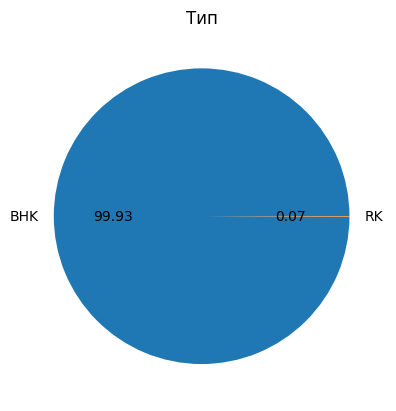

In [7]:
data['Тип'].value_counts().plot.pie(title='Тип', ylabel='', autopct='%.2f') # One-Hot
plt.show()

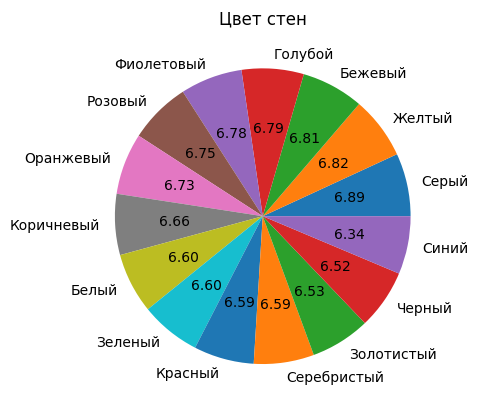

In [8]:
data['Цвет стен'].value_counts().plot.pie(title='Цвет стен', ylabel='', autopct='%.2f') #One-Hot
plt.show()

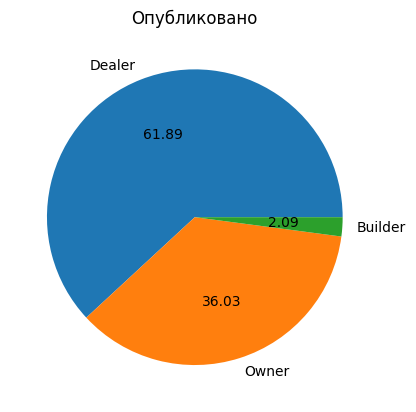

In [9]:
data['Опубликовано'].value_counts().plot.pie(title='Опубликовано', ylabel='', autopct='%.2f') #One-Hot
plt.show() #One-Hot

In [10]:
data.drop(columns=['Цена', "Тип", "Опубликовано", "Цвет стен", "Адрес"]).corr()

,id,Подтверждено риэлтором,Количество розеток,Долгота,Количество зеркал,Ремонтируется,Перепродажа,Готово к сдаче,Кол-во комнат,Площадь (фут²),Широта
id,1.000000,-0.002987,-0.006163,0.009080,-0.002487,0.012289,-0.006955,-0.012289,-0.012908,-0.000793,-0.008089
Подтверждено риэлтором,-0.002987,1.000000,0.002788,0.104407,-0.008560,0.360473,-0.269564,-0.360473,0.014602,-0.006341,-0.060994
Количество розеток,-0.006163,0.002788,1.000000,0.005376,-0.003386,-0.004939,0.005541,0.004939,-0.007591,-0.008259,-0.011631
Долгота,0.009080,0.104407,0.005376,1.000000,-0.009125,0.007527,0.026982,-0.007527,0.067437,-0.012695,-0.163106
Количество зеркал,-0.002487,-0.008560,-0.003386,-0.009125,1.000000,0.007366,-0.005331,-0.007366,0.007740,0.005480,0.011632
Ремонтируется,0.012289,0.360473,-0.004939,0.007527,0.007366,1.000000,-0.343242,-1.000000,-0.038620,-0.004307,0.003922
Перепродажа,-0.006955,-0.269564,0.005541,0.026982,-0.005331,-0.343242,1.000000,0.343242,0.012871,0.001925,0.017898
Готово к сдаче,-0.012289,-0.360473,0.004939,-0.007527,-0.007366,-1.000000,0.343242,1.000000,0.038620,0.004307,-0.003922
Кол-во комнат,-0.012908,0.014602,-0.007591,0.067437,0.007740,-0.038620,0.012871,0.038620,1.000000,0.006959,0.044332
Площадь (фут²),-0.000793,-0.006341,-0.008259,-0.012695,0.005480,-0.004307,0.001925,0.004307,0.006959,1.000000,0.000896


 **функциональная связь между "ремонтируется" и "готово к продаже"**

In [11]:
correlation = data.drop(columns=["Тип", "Опубликовано", "Цвет стен", "Адрес"]).corr()['Цена'].abs().sort_values()
correlation

Количество розеток        0.001124
id                        0.003656
Количество зеркал         0.004263
Широта                    0.017010
Долгота                   0.031127
Готово к сдаче            0.051343
Ремонтируется             0.051343
Подтверждено риэлтором    0.071512
Кол-во комнат             0.112195
Перепродажа               0.202524
Площадь (фут²)            0.425185
Цена                      1.000000
Name: Цена, dtype: float64

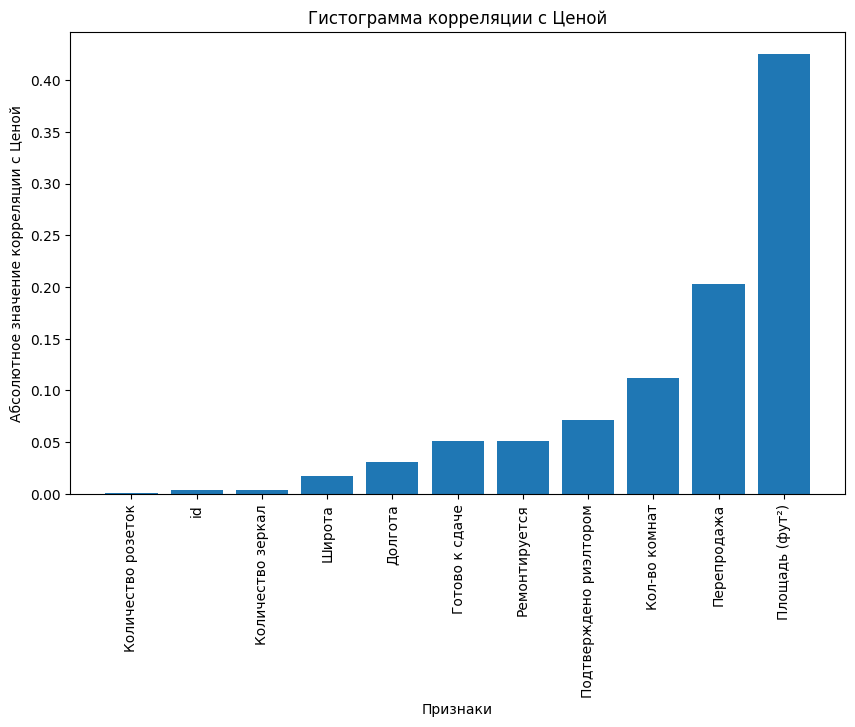

In [12]:
plt.figure(figsize=(10, 6))
plt.bar(correlation.index[:-1], correlation.values[:-1])
plt.xlabel('Признаки')
plt.ylabel('Абсолютное значение корреляции с Ценой')
plt.xticks(rotation=90)
plt.title('Гистограмма корреляции с Ценой')
plt.show()

**Удаляем столбцы "количество розеток", "id", "количество зеркал", "цвет стен", "Тип", "Готово к сдаче"**

# 3 Предобработка

In [14]:
data['Город'] = data['Адрес'].str.replace(',,', ',').str.split(',').str[1].str.lower()
data['Район'] = data['Адрес'].str.replace(',,', ',').str.split(',').str[0].str.lower()
data = data.drop(columns=['Адрес'])
data = data.drop(columns=['id', 'Готово к сдаче', 'Цвет стен', 'Тип', 'Количество розеток', 'Количество зеркал'])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['Цена']), data['Цена'], train_size=0.99, random_state=42)

In [16]:
data['Район'].unique().shape # количество уникальных районов

(5016,)

In [17]:
data['Город'].unique().shape # количество уникальных городов

(369,)

In [18]:
train = pd.concat([X_train, pd.DataFrame(y_train)], axis=1)

In [19]:
# межквартильный размах
Q1 = train['Цена'].quantile(0.25)
Q3 = train['Цена'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

train = train[(train['Цена'] >= lower_bound) & (train['Цена'] <= upper_bound)]
X_train, y_train = train.drop(columns='Цена'), train['Цена']

In [20]:
encoder = OneHotEncoder(handle_unknown='ignore')

tr = ColumnTransformer(
    [
        ("Район", encoder, ["Район"]),
        ("Опубликовано", encoder, ["Опубликовано"]),
        ("Город", encoder, ["Город"])
    ],
    remainder=RobustScaler()
).fit(X_train)

In [21]:
X_train = tr.transform(X_train)
X_test = tr.transform(X_test)

In [22]:
X_train = th.tensor(X_train.toarray(), dtype=th.float32)
X_test = th.tensor(X_test.toarray(), dtype=th.float32)

In [23]:
y_train = th.tensor(y_train.values, dtype=th.float32)
y_test = th.tensor(y_test.values, dtype=th.float32)

In [24]:
X_train.shape, X_test.shape

(torch.Size([19509, 5160]), torch.Size([220, 5160]))

# 4. Обучение

In [28]:
th.manual_seed(42)
lr = 0.0005
epochs = 2843

model = nn.Sequential(

        nn.Linear(5160, 50),
        nn.ReLU(),
        nn.BatchNorm1d(num_features=50),
        nn.Dropout(p=0.1),
        nn.Linear(50, 20),
        nn.ReLU(),
        nn.BatchNorm1d(num_features=20),
        nn.Dropout(p=0.1),
    
        nn.Linear(20, 1),
)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr)

train_losses = []
test_losses = []
best = [1000000, 0]

for epoch in tqdm(range(epochs + 1)):

    model.train()
    train_pred = model(X_train)
    train_loss = criterion(train_pred.flatten(), y_train)
    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    train_mape = mean_absolute_percentage_error(y_train, train_pred.detach().flatten()) * 100
    train_losses.append(train_mape)

    model.eval()
    test_pred = model(X_test)
    test_mape = mean_absolute_percentage_error(y_test, test_pred.detach().flatten()) * 100
    test_losses.append(test_mape)

    if test_mape < best[0]:
        best = [test_mape, epoch]

print(f'BEST MAPE {round(best[0], 5)} on epoch {best[1]}')

fig = go.Figure([go.Scatter(name = 'Train Loss', x = th.arange(epochs + 1), y = train_losses),
                 go.Scatter(name = 'Test Loss', x = th.arange(epochs + 1), y = test_losses)])
fig.show()

100%|██████████| 2844/2844 [14:08<00:00,  3.35it/s]

BEST MAPE 18.17532 on epoch 2843


# 5. Прогноз

In [30]:
test = pd.read_csv('/kaggle/input/pred-prices/test.csv')
test['Город'] = test['Адрес'].str.replace(',,', ',').str.split(',').str[1].str.lower()
test['Район'] = test['Адрес'].str.replace(',,', ',').str.split(',').str[0].str.lower()

test = test.drop(columns=['Адрес'])
test = test.drop(columns=['id', 'Готово к сдаче', 'Цвет стен', 'Тип', 'Количество розеток', 'Количество зеркал'])
test = tr.transform(test)
X_test_normalized = th.tensor(test.toarray(), dtype=th.float32)

In [31]:
model.eval()
test_pred = model(X_test_normalized)
data = [{"id": i, "Цена": value.item()} for i, value in enumerate(test_pred)]
df = pd.DataFrame(data)
df.to_csv('new.csv', index=False, encoding='utf-8')
df.head()

,id,Цена
0,0,22.361012
1,1,172.621490
2,2,32.483524
3,3,29.677944
4,4,93.728500
